# SwarmPRM  + Time

In [1]:
%matplotlib inline

## Road Map tests


#### Import and setup

In [2]:
import glob
from matplotlib import pyplot as plt
import numpy as np

from swarm_prm.envs.map import MapLoader
from swarm_prm.envs.instance import Instance
from swarm_prm.solvers.swarm_prm.macro.gaussian_utils import GaussianGraphNode
from swarm_prm.solvers.swarm_prm.macro.gaussian_prm import GaussianPRM


### Visualizing Maps

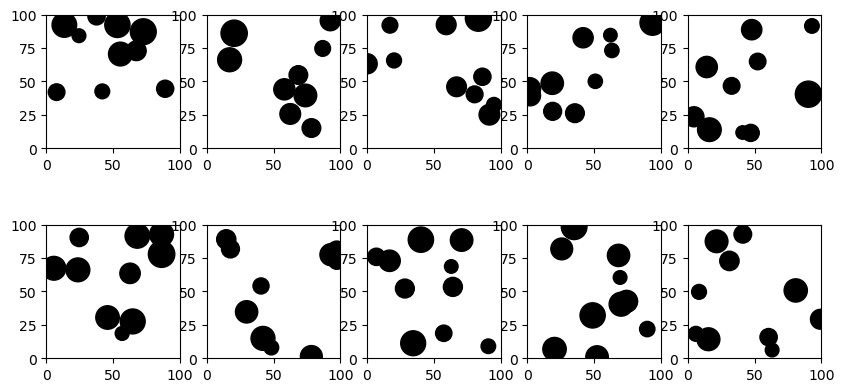

In [3]:
map_dir = "data/envs/maps/*"

fig, axs = plt.subplots(2, 5, figsize=(10, 5))

# Visualize the first 10 maps
for idx, map_fname in enumerate(glob.glob(map_dir)[:10]):
    row = idx // 5
    col = idx % 5
    map_loader = MapLoader(map_fname)
    map = map_loader.get_map()
    map.visualize(ax=axs[row][col])
    # instance_fname = "data/envs/maps/map_2.yaml"
    # instance = instance_loader.get_instance() 
    # gaussian_prm.load_instance()
    # gaussian_prm.build_roadmap(roadmap_method="KDTREE", kd_radius=30, collision_check_method="CVAR")

### Curated example

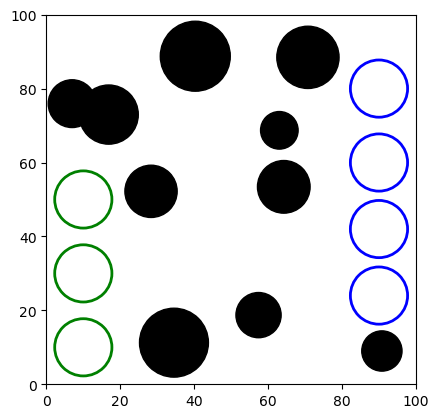

In [4]:
# Load map
map_fname = "data/envs/maps/map_7.yaml"
map_loader = MapLoader(map_fname)
map = map_loader.get_map()

# Curated test instance

starts = np.array([[10, 10], [10, 30], [10, 50]])
goals = np.array([[90, 42], [90, 60], [90, 80], [90, 24]])

starts_weight = np.array([0.3, 0.4, 0.3])
goals_weight = np.array([0.1, 0.2, 0.4, 0.3])

g_starts = [GaussianGraphNode(start, np.identity(2)*10) for start in starts]
g_goals = [GaussianGraphNode(goal, np.identity(2)*10) for goal in goals]

instance = Instance(map, g_starts, g_goals, starts_weight, goals_weight)
instance.visualize()



#### SwarmPRM sampling


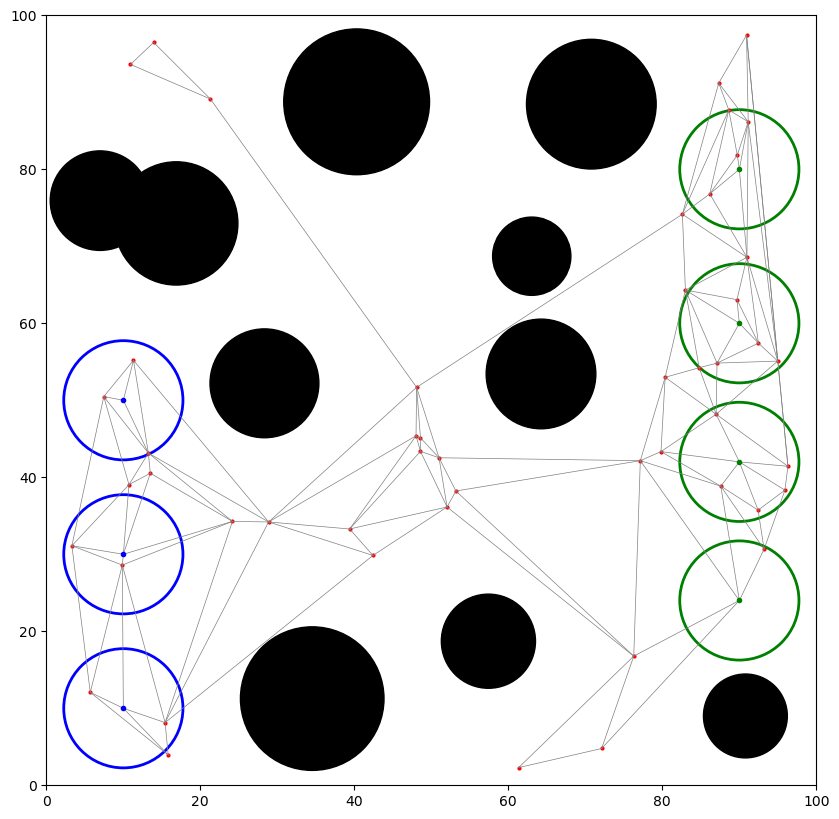

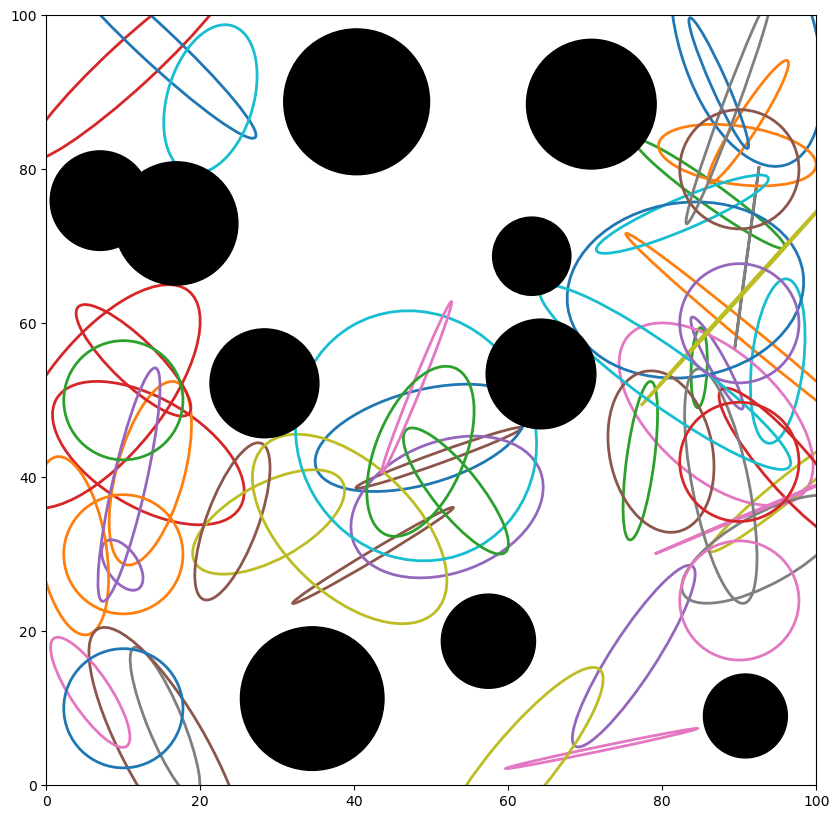

In [5]:
gaussian_prm = GaussianPRM(instance, 50)
gaussian_prm.sample_free_space(sampling_strategy="SWARMPRM")
gaussian_prm.load_instance()
gaussian_prm.build_roadmap(roadmap_method="TRIANGULATION", collision_check_method="CVAR")
gaussian_prm.visualize_roadmap("test_map")
gaussian_prm.visualize_g_nodes("test_g_nodes")

#### Gaussian with uniform covariance

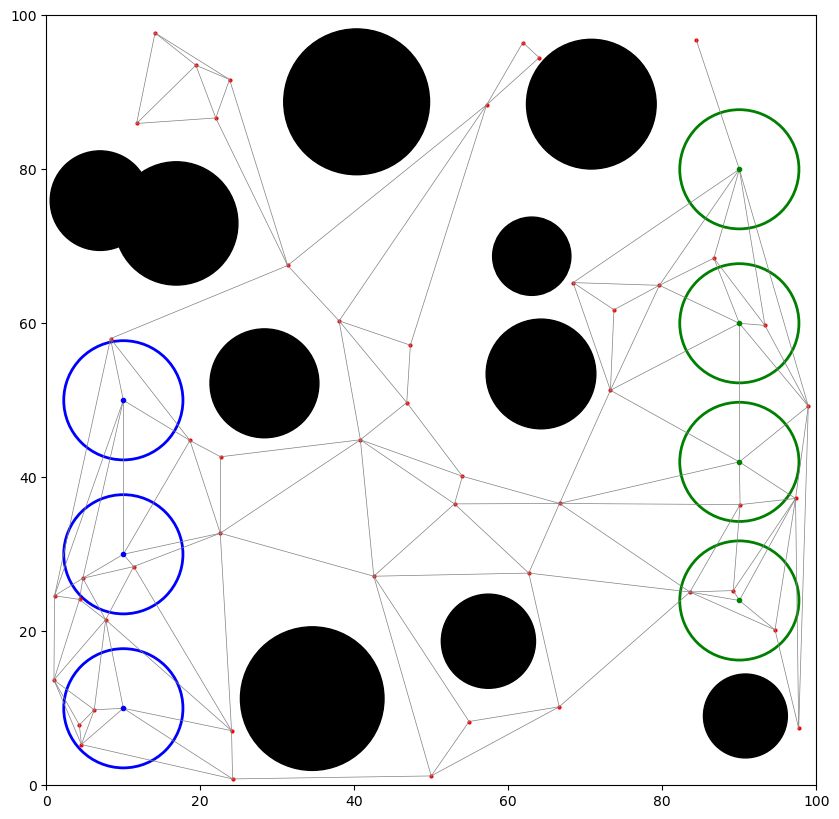

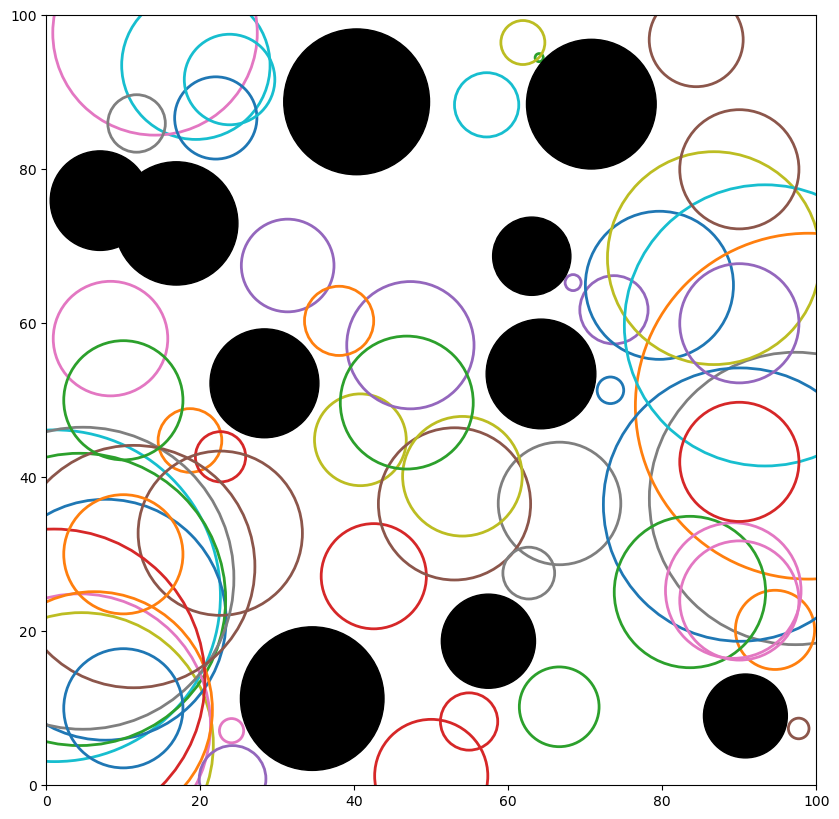

In [8]:
gaussian_prm = GaussianPRM(instance, 50)
gaussian_prm.sample_free_space(sampling_strategy="UNIFORM")
gaussian_prm.load_instance()
gaussian_prm.build_roadmap(roadmap_method="TRIANGULATION", collision_check_method="CVAR")
gaussian_prm.visualize_roadmap("test_map")
gaussian_prm.visualize_g_nodes("test_g_nodes")

#### CVAR test

In [ ]:

from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from scipy.stats import norm, chi2

from swarm_prm.solvers.swarm_prm.macro.gaussian_prm import GaussianNode
from swarm_prm.envs.map import Map, CircleObstacle


def obstacle_gaussian_collision(obs: CircleObstacle, g_node: GaussianNode, alpha, thresh, ax) -> bool:
    """
        Using CVaR and threshold to test if node is too close to obstacle.
        Return True if CVaR is greater than the threshold.
        Reference: SwarmPRM
    """

    # Plot normal vector
    mean = -obs.get_dist(g_node.get_mean())
    v_normal = (obs.pos - g_node.get_mean()) / (np.linalg.norm(obs.pos - g_node.get_mean()))
    start_pos = g_node.get_mean()
    end_pos = start_pos - v_normal * mean
    vec = np.vstack([start_pos, end_pos]).T
    ax.plot(vec[0], vec[1])

    variance = v_normal.T @ g_node.covariance @ v_normal
    ita = norm(mean, variance)
    cvar = mean + ita.pdf(ita.ppf(1-alpha))/alpha * variance
    print(cvar)
    return cvar > thresh

def visualize_g_node(g_node, ax, thresh, is_collision):
    # Visualize G nodes
    mean, cov = g_node.get_gaussian()
    # Compute the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    # Sort eigenvalues and eigenvectors by descending eigenvalue
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # The angle of the ellipse (in degrees)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # The width and height of the ellipse (2*sqrt(chi2_value*eigenvalue))
    chi2_value = chi2.ppf(thresh, 2)  # threshold confidence interval for 2 degrees of freedom (chi-squared value)
    width, height = 2 * np.sqrt(chi2_value * eigenvalues)
    if is_collision:
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                          edgecolor="red", fc='None', lw=2)
    else:
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                          edgecolor="blue", fc='None', lw=2)
    ax.add_patch(ellipse)


-29.684271490790742
-27.501868105511107
-25.395681057797034
-23.38009375579101
-21.4724579380292
-19.693510797376312
-18.067637749474535
-16.62278454540095
-15.389742067749124
-14.40049956523132
-13.685484596776222
-13.269871954457441
-13.169703847988606
-13.389014760485077
-13.919058197821139
-14.739957417261506
-15.824105974851255
-17.140100089676345
-18.656136320980476
-20.342351284534654


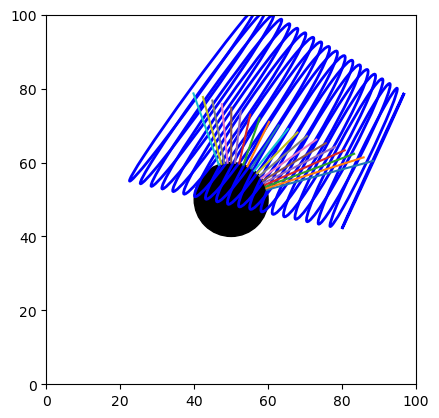

In [ ]:

roadmap = Map(100, 100)
pos = np.array([50, 50])
obs = CircleObstacle(pos, 10)
thresh = -8
tolerance = 0.95
alpha = 0.95 
num_g_node = 20 

roadmap.add_obstacle(obs)
fig, ax = roadmap.visualize()
start_mean = np.random.rand(2) * 100
goal_mean = np.random.rand(2) * 100

temp = np.random.rand(2, 2) * 10
start_cov =  temp @ temp.T
temp = np.random.rand(2, 2) * 10
goal_cov =  temp @ temp.T

for i in range(num_g_node):
    mean = i / (num_g_node) * start_mean + (num_g_node - i) / num_g_node * goal_mean
    cov = i / (num_g_node) * start_cov + (num_g_node - i) / num_g_node * goal_cov

    g_node = GaussianNode(mean, cov)
    is_collision = obstacle_gaussian_collision(obs,  g_node, alpha, thresh, ax)
    visualize_g_node(g_node, ax, tolerance, is_collision)

#### TEG test

Earliest timestep to reach max flow 5: None


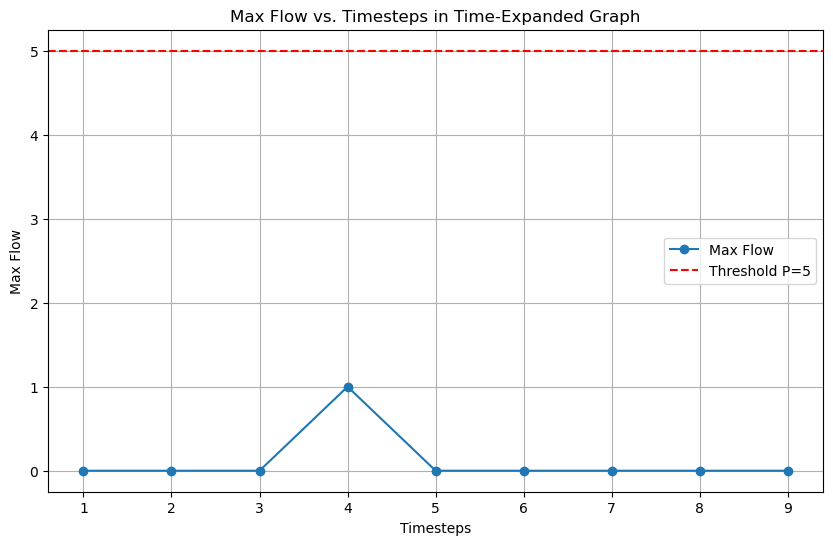

In [ ]:
from collections import defaultdict, deque
import matplotlib.pyplot as plt

class TEGGraph:
    def __init__(self, vertices, vertex_capacities):
        self.static_graph = defaultdict(list)
        self.vertex_capacities = vertex_capacities
        self.vertices = vertices
        self.flow_values = []  # To store flow values for visualization

    def add_edge(self, u, v, capacity):
        """Add an edge to the static graph with a given capacity."""
        self.static_graph[u].append((v, capacity))
        self.static_graph[v].append((u, 0))  # Reverse edge for flow calculations

    def build_teg(self, timesteps):
        """Build the time-expanded graph (TEG)."""
        self.teg_graph = defaultdict(list)
        
        # Create nodes for each time layer
        for i in range(timesteps):
            for u in self.vertices:
                self.teg_graph[(u, i)] = []
        
        # Connect nodes based on reachability in the static graph
        for i in range(timesteps - 1):
            for u in self.vertices:
                for v, capacity in self.static_graph[u]:
                    self.teg_graph[(u, i)].append(((v, i+1), min(capacity, self.vertex_capacities[v])))

    def bfs(self, source, sink, parent):
        """Breadth-First Search to find an augmenting path."""
        visited = set()
        queue = deque([source])
        visited.add(source)
        
        while queue:
            u = queue.popleft()
            
            for v, capacity in self.teg_graph[u]:
                if v not in visited and capacity > 0:  # Not yet visited and capacity is positive
                    parent[v] = u
                    if v == sink:
                        return True
                    queue.append(v)
                    visited.add(v)
        
        return False

    def edmonds_karp(self, source, sink):
        """Edmonds-Karp implementation to find max flow."""
        parent = {}
        max_flow = 0
        
        while self.bfs(source, sink, parent):
            path_flow = float('Inf')
            s = sink
            
            while s != source:
                u = parent[s]
                for v, capacity in self.teg_graph[u]:
                    if v == s:
                        path_flow = min(path_flow, capacity)
                s = parent[s]
            
            max_flow += path_flow
            v = sink
            
            while v != source:
                u = parent[v]
                for i, (adj_v, capacity) in enumerate(self.teg_graph[u]):
                    if adj_v == v:
                        self.teg_graph[u][i] = (adj_v, capacity - path_flow)
                for i, (adj_v, capacity) in enumerate(self.teg_graph[v]):
                    if adj_v == u:
                        self.teg_graph[v][i] = (adj_v, capacity + path_flow)
                v = parent[v]
        
        return max_flow

    def find_earliest_timestep_with_threshold(self, P):
        """Find the earliest timestep where the max flow reaches or exceeds threshold P."""
        timesteps = 1
        
        while True and timesteps < 10:
            self.build_teg(timesteps)
            source = (self.vertices[0], 0)  # Assuming first vertex as the source
            sink = (self.vertices[-1], timesteps - 1)  # Assuming last vertex as the sink
            
            max_flow = self.edmonds_karp(source, sink)
            self.flow_values.append(max_flow)  # Store flow value for visualization
            
            if max_flow >= P:
                return timesteps
            
            timesteps += 1  # Add an extra layer and try again

    def visualize_flow(self, P):
        """Visualize the max flow as a function of timesteps and show the threshold line."""
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(self.flow_values) + 1), self.flow_values, marker='o', label='Max Flow')
        plt.axhline(y=P, color='r', linestyle='--', label=f'Threshold P={P}')
        plt.xlabel('Timesteps')
        plt.ylabel('Max Flow')
        plt.title('Max Flow vs. Timesteps in Time-Expanded Graph')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage:
vertices = ['A', 'B', 'C', 'D']
vertex_capacities = {'A': 3, 'B': 2, 'C': 1, 'D': 4}

teg = TEGGraph(vertices, vertex_capacities)
teg.add_edge('A', 'B', 3)
teg.add_edge('B', 'C', 2)
teg.add_edge('C', 'D', 4)

P = 5  # Threshold for max flow
earliest_timestep = teg.find_earliest_timestep_with_threshold(P)
print(f"Earliest timestep to reach max flow {P}: {earliest_timestep}")

# Visualize the process
teg.visualize_flow(P)


In [ ]:
from collections import deque, defaultdict

class MaxFlowWithVertexCapacity:
    def __init__(self, graph, vertex_capacity):
        self.original_graph = graph  # adjacency list of the original graph
        self.vertex_capacity = vertex_capacity  # vertex capacities
        self.modified_graph = self.build_modified_graph()

    def build_modified_graph(self):
        """Splits each vertex with a capacity into two vertices connected by an edge with the vertex capacity."""
        modified_graph = defaultdict(list)
        self.new_vertex_index = max(self.original_graph) + 1

        for u in self.original_graph:
            for v, capacity in self.original_graph[u]:
                if u in self.vertex_capacity:
                    # Split the vertex u into u_in and u_out
                    u_in = u
                    u_out = self.new_vertex_index
                    self.new_vertex_index += 1
                    # Add the internal edge with the vertex capacity
                    modified_graph[u_in].append((u_out, self.vertex_capacity[u]))
                    modified_graph[u_out].append((u_in, 0))  # Reverse edge for residual graph
                    # Add the original edge to the modified graph
                    modified_graph[u_out].append((v, capacity))
                    modified_graph[v].append((u_out, 0))  # Reverse edge for residual graph
                else:
                    # If there's no vertex capacity constraint, add the edge normally
                    modified_graph[u].append((v, capacity))
                    modified_graph[v].append((u, 0))  # Reverse edge for residual graph

        return modified_graph

    def bfs(self, s, t, parent):
        visited = [False] * self.new_vertex_index
        queue = deque([s])
        visited[s] = True

        while queue:
            u = queue.popleft()

            for v, capacity in self.modified_graph[u]:
                if visited[v] is False and capacity > 0:
                    queue.append(v)
                    visited[v] = True
                    parent[v] = u

                    if v == t:
                        return True
        return False

    def edmonds_karp(self, source, sink):
        parent = [-1] * self.new_vertex_index
        max_flow = 0

        while self.bfs(source, sink, parent):
            path_flow = float('Inf')
            s = sink

            while s != source:
                path_flow = min(path_flow, self.modified_graph[parent[s]][[v for v, cap in self.modified_graph[parent[s]]].index(s)][1])
                s = parent[s]

            max_flow += path_flow

            v = sink
            while v != source:
                u = parent[v]
                self.modified_graph[u][[n for n, cap in self.modified_graph[u]].index(v)] = (v, self.modified_graph[u][[n for n, cap in self.modified_graph[u]].index(v)][1] - path_flow)
                self.modified_graph[v][[n for n, cap in self.modified_graph[v]].index(u)] = (u, self.modified_graph[v][[n for n, cap in self.modified_graph[v]].index(u)][1] + path_flow)
                v = parent[v]

        return max_flow

# Example usage:
graph = {
    0: [(1, 16), (2, 13)],
    1: [(3, 12)],
    2: [(1, 4), (4, 14)],
    3: [(2, 9), (5, 20)],
    4: [(3, 7), (5, 4)],
    5: []
}
vertex_capacity = {
    1: 20,  # Capacity of vertex 1
    3: 30   # Capacity of vertex 3
}

max_flow_solver = MaxFlowWithVertexCapacity(graph, vertex_capacity)
source = 0  # source node
sink = 5    # sink node

print(f"The maximum possible flow is {max_flow_solver.edmonds_karp(source, sink)}")


The maximum possible flow is 23
